In [6]:
# Random Forest – Challenge: Marine Engine Maintenance Prediction

## Overview

In this notebook, we’ll explore how to use a Random Forest classifier to predict engine maintenance status based on telemetry data. No prior experience with ensemble methods is required. We will:

- Introduce the Random Forest algorithm and its strengths  
- Load and inspect the marine engine dataset  
- Preprocess both numeric and categorical features  
- Split the data into stratified training and test sets  
- Build and evaluate a Random Forest model  
- Evaluate model performance with accuracy, classification report, and confusion matrix  
- Visualize the top feature importances  

**Can we accurately predict maintenance needs based solely on sensor and usage data?**


In [25]:
# %% [markdown]
# # Random Forest Analysis on Marine Engine Data
# 
# In this notebook, we will:
# 1. Load and inspect the data  
# 2. Preprocess numeric and categorical features  
# 3. Split into train/test sets  
# 4. Build and tune a Random Forest via GridSearchCV  
# 5. Evaluate performance (classification report, confusion matrix, ROC)  
# 6. Visualize top feature importances  

# %% 

!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [28]:
# %% [markdown]
## 1. Load & Inspect Data

# %% 
# Load CSVb
df = pd.read_csv('Data/marine_engine_data.csv')

# Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nTarget distribution:\n", df['maintenance_status'].value_counts())

df.head()

Shape: (5200, 17)

Columns:
 ['timestamp', 'engine_id', 'engine_temp', 'oil_pressure', 'fuel_consumption', 'vibration_level', 'rpm', 'engine_load', 'coolant_temp', 'exhaust_temp', 'running_period', 'fuel_consumption_per_hour', 'maintenance_status', 'failure_mode', 'engine_type', 'fuel_type', 'manufacturer']

Target distribution:
 maintenance_status
Requires Maintenance    1756
Critical                1740
Normal                  1704
Name: count, dtype: int64


,timestamp,engine_id,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour,maintenance_status,failure_mode,engine_type,fuel_type,manufacturer
0,2023-01-01,ENG_001,79.816406,7.049409,1000.000000,4.366612,1770.214578,42.472407,78.323108,450.0,49.741791,100.0,Critical,Oil Leakage,4-stroke High-Speed,Diesel,MAN B&W
1,2023-01-08,ENG_001,98.982068,8.000000,6308.623817,3.732792,1677.238238,77.042858,100.000000,450.0,94.351515,100.0,Requires Maintenance,Oil Leakage,2-stroke Low-Speed,Diesel,Mitsubishi
2,2023-01-15,ENG_001,83.918153,8.000000,6444.402260,4.061372,1487.472085,63.919637,78.178337,450.0,120.095804,100.0,Normal,No Failure,2-stroke Medium-Speed,Diesel,Caterpillar
3,2023-01-22,ENG_001,81.887081,7.601603,4439.946613,3.999554,1548.624692,55.919509,82.896344,450.0,122.321555,100.0,Requires Maintenance,Mechanical Wear,2-stroke Medium-Speed,Diesel,MAN B&W
4,2023-01-29,ENG_001,78.550429,6.233033,3146.234038,4.520559,1441.151499,29.361118,80.791150,450.0,111.978460,100.0,Normal,No Failure,4-stroke High-Speed,Diesel,Wärtsilä


In [29]:
# %% [markdown]
## 2. Preprocessing

# %%
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Drop the target column for preprocessing
df_features = df.drop('maintenance_status', axis=1)

# Identify numeric and categorical columns
numeric_cols = df_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns.tolist()

# Build the preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

Numeric cols: ['engine_temp', 'oil_pressure', 'fuel_consumption', 'vibration_level', 'rpm', 'engine_load', 'coolant_temp', 'exhaust_temp', 'running_period', 'fuel_consumption_per_hour']
Categorical cols: ['timestamp', 'engine_id', 'failure_mode', 'engine_type', 'fuel_type', 'manufacturer']


In [30]:
# %% [markdown]
## 3. Train/Test Split

# %%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target to numeric
le = LabelEncoder()
y = le.fit_transform(df['maintenance_status'])

# Features (without target)
X = df.drop('maintenance_status', axis=1)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

Train set: (3640, 16) Test set: (1560, 16)


In [31]:
# %% [markdown]
## 4. Build & Tune Random Forest

# %%
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocess -> RandomForest
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Grid of hyperparameters
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"Best CV ROC AUC: {grid.best_score_:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best CV ROC AUC: 0.351


C:\Users\ValerieAnnabella\AppData\Local\Temp\ipykernel_27028\989113332.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


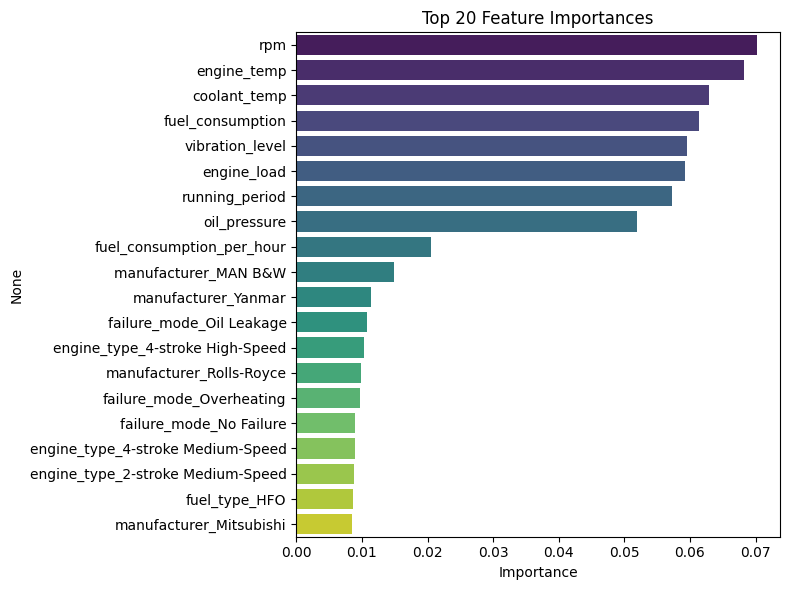

In [32]:
# %% [markdown]
## 5. Evaluation on Test Set

# %%
# Retrieve the fitted pipeline from GridSearchCV
pipeline = grid.best_estimator_

# Extract the fitted preprocessor
fitted_preproc = pipeline.named_steps['preprocess']

# Get the fitted OneHotEncoder for categorical cols
ohe = fitted_preproc.named_transformers_['cat']

# Get feature names from numeric and categorical
if hasattr(ohe, 'get_feature_names_out'):
    cat_features = ohe.get_feature_names_out(categorical_cols)
else:
    cat_features = ohe.get_feature_names(categorical_cols)

feature_names = numeric_cols + list(cat_features)

# Get feature importances
rf = pipeline.named_steps['rf']
importances = rf.feature_importances_

# Plot top 20
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
sns.barplot(x=fi.values, y=fi.index, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()